<a href="https://colab.research.google.com/github/CyberPsyLen/classifiers/blob/main/flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

## Download and explore the dataset

In [2]:
# Connect to GDrive
from google.colab import drive
drive.mount('/content/drive')

# locate dataset
# contains subdirs: sunflower/rose/hydranger
data_path = '/content/drive/MyDrive/ML Projects/Flower Classifier/dataset'
data_dir = pathlib.Path(data_path)

print(data_dir)

Mounted at /content/drive
/content/drive/MyDrive/ML Projects/Flower Classifier/dataset


In [3]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

2428


Here are some roses:

There are this many rose images: 779
here is a random one:


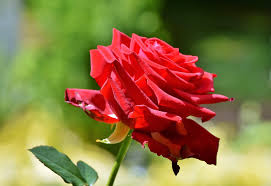

In [4]:
import random
rose_cnt = len(list(data_dir.glob('rose/*.jpeg')))
print('There are this many rose images:', rose_cnt)
print('here is a random one:')
rand_ix = random.randint(0, rose_cnt)
roses = list(data_dir.glob('rose/*'))
PIL.Image.open(str(roses[rand_ix]))

There are this many sunflowers: 662
here is a random one:


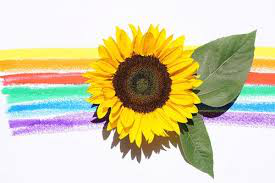

In [5]:
sunflower_cnt = len(list(data_dir.glob('sunflower/*.jpeg')))
print('There are this many sunflowers:', sunflower_cnt)
print('here is a random one:')
rand_ix = random.randint(0, sunflower_cnt)
sunflowers = list(data_dir.glob('sunflower/*'))
PIL.Image.open(str(sunflowers[rand_ix]))

There are this many hydrangers: 987
here is a random one:


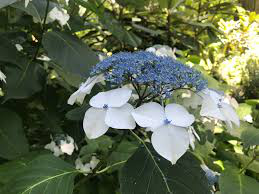

In [6]:
hydranger_cnt = len(list(data_dir.glob('hydranger/*.jpeg')))
print('There are this many hydrangers:', hydranger_cnt)
print('here is a random one:')
rand_ix = random.randint(0, hydranger_cnt)
hydrangers = list(data_dir.glob('hydranger/*'))
PIL.Image.open(str(hydrangers[rand_ix]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [33]:
# define loader params
batch_size = 10 # 32 was not working
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [34]:
# training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2459 files belonging to 3 classes.
Using 1968 files for training.


In [35]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2459 files belonging to 3 classes.
Using 491 files for validation.


In [36]:
# verify class names
class_names = train_ds.class_names
print(class_names)

['hydranger', 'rose', 'sunflower']


## Visualize the data

Here are the first nine images from the training dataset:

In [37]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [38]:
# check shape of data
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 180, 180, 3)
(10,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [40]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [41]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image)) 

Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

In [42]:
num_classes = len(class_names)

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

## Model summary

View all the layers of the network using the model's `Model.summary` method:

## Train the model

## Overfitting

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [43]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

In [44]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
  # for i in range(9):
  #   augmented_images = data_augmentation(images)
  #   ax = plt.subplot(3, 3, i + 1)
  #   plt.imshow(augmented_images[0].numpy().astype("uint8"))
  #   plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [45]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [48]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
197/197 [==============================] - 7s 16ms/step - loss: 0.8348 - accuracy: 0.6916 - val_loss: 0.5276 - val_accuracy: 0.7963
Epoch 2/30
197/197 [==============================] - 2s 11ms/step - loss: 0.4803 - accuracy: 0.8206 - val_loss: 0.4616 - val_accuracy: 0.8045
Epoch 3/30
197/197 [==============================] - 2s 11ms/step - loss: 0.4315 - accuracy: 0.8379 - val_loss: 0.4463 - val_accuracy: 0.8248
Epoch 4/30
197/197 [==============================] - 2s 11ms/step - loss: 0.4113 - accuracy: 0.8435 - val_loss: 0.4393 - val_accuracy: 0.8269
Epoch 5/30
197/197 [==============================] - 2s 11ms/step - loss: 0.4045 - accuracy: 0.8516 - val_loss: 0.4156 - val_accuracy: 0.8595
Epoch 6/30
197/197 [==============================] - 2s 11ms/step - loss: 0.3967 - accuracy: 0.8567 - val_loss: 0.5105 - val_accuracy: 0.7862
Epoch 7/30
197/197 [==============================] - 2s 11ms/step - loss: 0.3799 - accuracy: 0.8491 - val_loss: 0.4101 - val_accuracy: 0.8310

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

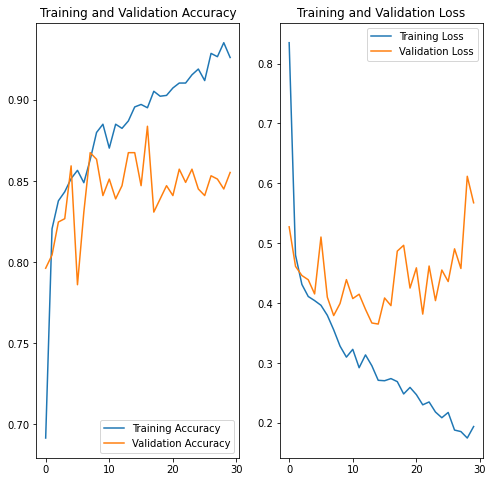

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [111]:
def predict_flower(img_path):
  # print('predicting on', img_path)
  img = image.load_img(img_path, target_size=(img_height, img_width))
  plt.imshow(img)
  plt.show()

  img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  # print(img_array[:50])

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  # print(predictions)
  # print(score)
  # print(class_names)


  print("I think this is a {}, I am {:.2f} confident.".format(class_names[np.argmax(score)], 100 * np.max(score)))
  print("")
  print("")

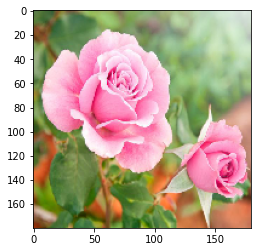

I think this is a hydranger, I am 90.55 confident.




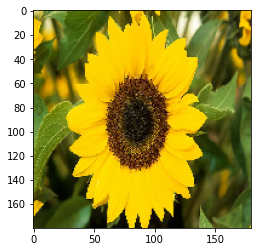

I think this is a sunflower, I am 100.00 confident.




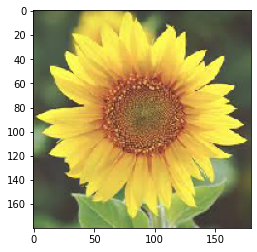

I think this is a sunflower, I am 89.66 confident.




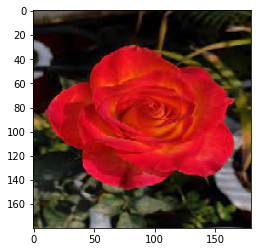

I think this is a rose, I am 100.00 confident.




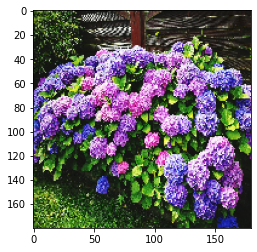

I think this is a hydranger, I am 100.00 confident.




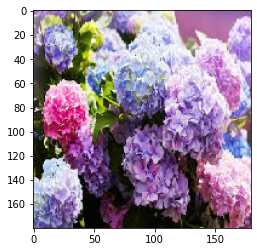

I think this is a hydranger, I am 99.37 confident.




In [112]:
# Make predictions for all images in the predict folder
predict_path = '/content/drive/MyDrive/ML Projects/Flower Classifier/predict/'
for filename in os.listdir(predict_path):
    if filename.endswith("jpeg"): 
        filename = predict_path + filename  # concat dir
        predict_flower(filename)